# Lime: "Why Should I Trust You?": Explaining the Predictions of Any Classifier

The first explainability algorithm we want to look at is Lime (https://arxiv.org/abs/1602.04938). 

We will use the dedicated python library lime for our analyis.

In [28]:
# Start with imports again
from lime import lime_image
import numpy as np
import medmnist
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

Let's start with loading the petrained classifier model:

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load("../Exercise/best_dermamnist_resnet_model.pth", map_location=device))

<All keys matched successfully>

Then, just as in the model training notebook, we get test data that we want to classify.

In [33]:
data_flag = 'dermamnist'
info = medmnist.INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

mean = 0.5
std = 0.5
batch_size = 128

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_dataset = DataClass(split='test', transform=data_transform, size=64, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Get the first batch of data:

In [36]:
images, labels = next(iter(test_loader))
images = images.to(device)

## **Applying Lime**

To understand why our classifier behaves the way it does, we can use LimeImageExplainer().
LimeImageExplainer requires two inputs. First, we need to provide an image that we want to analyze. Second, we need to provide a function that can be used to predict the perturbed images.

In [130]:
# To DO
# 1. Select an image from images.
# 2. Lime expects input images with HeightxWidthx3, with the last dimension beeing the RGB channels.
# Our images are currently in the form of 3xHxW. We need to permute the dimensions in the right order.
# 3. Convert tensor to numpy array and name image img_np
# 4. Undo normalization step

# -> Solution
image_idx_to_explain = 0
img_t = images[image_idx_to_explain].cpu()                                  
img_np = img_t.permute(1, 2, 0).numpy()
img_np = img_np*std + mean

In [132]:
# To Do
# Complete the function

def batch_predict(images):
  
    # 1. Set model in evaluation mode
    # 2. Repermute image dimensions to align with the model
    # 3. Do normalization
    # 4. Predict on images
    # 5. Apply softmax function and detach output

    return probabilities

# -> Solution
def batch_predict(images):
    model.eval()
    images= torch.tensor(images).permute(0, 3, 1, 2).float()
    images = (images - mean) / std
    logits = model(images)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy() 

Then we can bring everything together:

In [135]:
# custom segmentation map, because of image size.
segmentation_fn = lambda x: slic(x, n_segments=30, compactness=10, sigma=1, start_label=1)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_np,
                                         batch_predict,
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000,
                                         segmentation_fn=segmentation_fn) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 441.40it/s]


Let's have a look at the results:

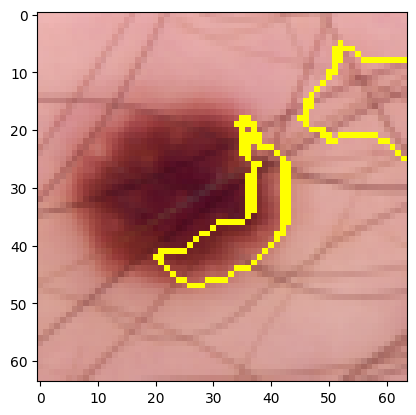

In [137]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
img_boundry2 = mark_boundaries(temp, mask)


plt.imshow(np.clip(img_boundry2, 0, 1))
plt.show()